# How to run Qiskit on Amazon Braket

In [17]:
!pip list

Package                           Version
--------------------------------- --------------
aiobotocore                       2.14.0
aiofiles                          22.1.0
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.11.0
aiosignal                         1.3.1
aiosqlite                         0.20.0
amazon-braket-default-simulator   1.26.0
amazon-braket-schemas             1.22.1
amazon-braket-sdk                 1.87.1
annotated-types                   0.7.0
antlr4-python3-runtime            4.9.2
anyio                             4.4.0
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
astroid                           3.2.4
asttokens                         2.4.1
async-lru                         2.0.4
async-timeout                     4.0.3
attrs                             23.2.0
autopep8                          2.0.4
autovizwidget     

In [18]:
!pip install qiskit_braket_provider

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 20.3 MB/s eta 0:00:00:00:0100:01


In [19]:
!pip show qiskit_braket_provider

Name: qiskit-braket-provider
Version: 0.4.1
Summary: Qiskit-Braket provider to execute Qiskit programs on AWS quantum computing hardware devices through Amazon Braket.
Home-page: UNKNOWN
Author: 
Author-email: 
License: UNKNOWN
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: amazon-braket-sdk, certifi, numpy, qiskit, qiskit-ionq, setuptools
Required-by: 


In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

If you're like many people who learned quantum computing in the past several years, you might have learned how to program quantum circuits with [Qiskit](https://qiskit.org): the open-source quantum Software Development Kit (SDK) first released in 2017. With the [Qiskit-Braket provider](https://github.com/qiskit-community/qiskit-braket-provider/blob/main/docs/tutorials/0_tutorial_qiskit-braket-provider_overview.ipynb), you can run your Qiskit code across any of the gate-based devices on the [Amazon Braket](https://aws.amazon.com/braket/) quantum computing service.

**Note**: if you're running this in your local development environment (i.e. not from the Braket console), you'll need to make sure you've got your AWS account configured properly first to access Braket devices. Check out [this tutorial](https://aws.amazon.com/blogs/quantum-computing/setting-up-your-local-development-environment-in-amazon-braket/) for a walkthrough.

## Access Braket devices from Qiskit 

 There are quite a few different backend devices on Amazon Braket, so we'll walk through them one by one and give an example of recommended use cases for each.

### Quantum simulators
Let's start with the ***local simulator***. This is a quantum full state vector simulator which runs *locally* -- that means wherever you're running this Jupyter notebook (e.g. your local development environment or a notebook instance on the Braket console).

**Recommended use case:** Noiseless circuits up to ~12 qubits

In [2]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()

Next, we have the ***local density matrix simulator***. This simulator also runs on your local machine, but allows you to simulate the effects of *noise* on your quantum circuit. Because density matrices are twice the size of state vectors, the number of qubits you can effectively simulate is half the size as the local state vector simulator.

**Recommended use case:** Noisy circuits up to ~6 qubits

In [3]:
local_dm_simulator = BraketLocalBackend(name='braket_dm')

Now let's look at Braket's *on-demand* simulators: these run on AWS computing resources and have some expanded features in addition to those of the local simulator. We can list all the available Braket simulators with the following code:

In [4]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()

provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

First up for on-demand simulators is ***SV1***. This is a full state vector simulator which allows you to simulate larger circuits than the local simulator, along with the ability to [batch tasks](https://docs.aws.amazon.com/braket/latest/developerguide/braket-batching-tasks.html) and run them in parallel, as well as use advanced techniques like [adjoint gradient calculations](https://pennylane.ai/blog/2022/12/computing-adjoint-gradients-with-amazon-braket-sv1/) for variational quantum algorithms. 

**Recommended use case:** Noiseless variational algorithms on up to 34 qubits

In [5]:
sv1 = provider.get_backend("SV1")

The next on-demand simulator is ***DM1***. This is a density matrix simulator which, like SV1, allows you to simulate a larger number of qubits, as well as take advantage of batch execution. 

**Recommended use case:** Noisy variational algorithms on up to 17 qubits

In [6]:
dm1 = provider.get_backend("dm1")

Lastly for on-demand simulators, we have ***TN1***. This is a tensor-network simulator, which represents each gate in a circuit as a tensor. TN1 can simulate a larger number of qubits for circuits with local gates or other special structure, but will typically be slower than SV1 or DM1 for circuits with long-range or all-to-all gate structure.

**Recommended use case:** Noiseless quantum circuits with local connectivity and up to 50 qubits

**Note**: Each AWS resource, (like a file or CPU or QPU) lives in a specific region and may only be accessible from that region. For example, TN1 is only available in the `eu-west-2`, `us-east-1`, and `us-west-2` regions. 

To change your AWS region if you're running in a managed notebook, you'll need to use the GUI in the top right hand corner of the AWS console to select your new region, then relaunch or create your notebook from the Braket console.

To change your AWS region if you're running in your local development environment, you run the following code snippet:
```
import os
os.environ["AWS_REGION"] = "your-desired-region"
```

In [7]:
# If you've switched to one of the regions where TN1 is accessible, feel free to uncomment the following code
# tn1 = provider.get_backend("TN1")

### Quantum Processing Units (QPUs)

Amazon Braket also provides access to a number of third-party quantum hardware devices. The following code shows how to view the supported QPUs which are currently online:

In [8]:
provider.backends(statuses=["ONLINE"], types=["QPU"])

[BraketBackend[Ankaa-2],
 BraketBackend[Aria 1],
 BraketBackend[Forte 1],
 BraketBackend[Garnet]]

For a closer look at each quantum computer, you can peruse the [Providers Overview](https://aws.amazon.com/braket/quantum-computers/) on the Braket homepage, or the Devices tab on the left side of the Braket console. 
Currently only gate-based QPUs (IonQ, Rigetti) are supported with the Qiskit-Braket provider. 

## Running circuits on Braket devices



Now that we've walked through each of the quantum devices available through the Qiskit-Braket provider, let's take them for a spin! For this example, we'll create a 3-GHZ state on the Rigetti device, but feel free to choose a different QPU from the commented out devices below.

In [9]:
qpu_backend = provider.get_backend("Aspen-M-3")
# qpu_backend = provider.get_backend("Aria")

print(qpu_backend)

BraketBackend[Aspen-M-3]


In [21]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.draw("mpl")

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [11]:
# run circuit
qpu_backend=sv1
qpu_task = qpu_backend.run(circuit, shots=10)

Each quantum task you run is assigned a unique ARN (Amazon Resource Name), which you can save and use to retrieve the data for your quantum task after its run, even if you close your notebook.

In [12]:
task_id = qpu_task.task_id()
task_id

'arn:aws:braket:us-east-1:746669231099:quantum-task/5c69ec16-8e8c-4826-8904-5f135d7e96b7'

Now, Braket has a separate feature called \"Hybrid *Jobs*\", which is beyond the scope of this notebook, but which you can read about in the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html).

In [13]:
# Retrieve quantum task data
retrieved_task = qpu_backend.retrieve_job(task_id=task_id)

Then you can check the status of the task to see if it's finished:

In [14]:
retrieved_task.status()

<JobStatus.DONE: 'job has successfully run'>

**Note:** different devices may have different availability windows, so while your task may not run right away, rest assured it will be added to the queue to be run when the device is back online.

When your task is finished, you can retrieve the data:

In [15]:
data = retrieved_task.result()

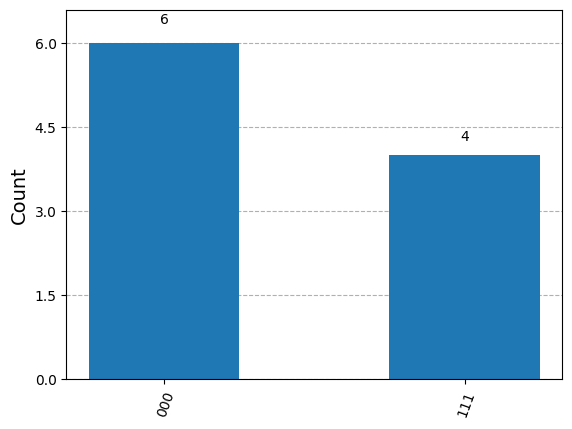

In [16]:
from qiskit.visualization import plot_histogram
plot_histogram(data.get_counts())